In [1]:
import matplotlib as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# We will use kernel regularizers to implement weight decay

from tensorflow.keras.regularizers import L1L2
dense_regularizer = L1L2(l2=0.0001)
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix

Convolution layers work better when we initialize kernel with he_normal and use elu instead of relu

In [2]:
BATCH_SIZE = 128

def create_vgg16(x=None):
    # we initialize the model
    model = Sequential()
    
    

    # Conv Block 1
    model.add(Conv2D(64, (5, 5), input_shape=(32,32,3),  padding='same', kernel_regularizer=dense_regularizer,kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Conv2D(64, (5, 5),   padding='same', kernel_regularizer=dense_regularizer,kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Conv2D(64, (5, 5),  padding='same', kernel_regularizer=dense_regularizer,kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 2
    model.add(Conv2D(128, (3, 3),  padding='same', kernel_regularizer=dense_regularizer,kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Conv2D(128, (3, 3),  padding='same', kernel_regularizer=dense_regularizer,kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Conv2D(128, (3, 3),  padding='same', kernel_regularizer=dense_regularizer,kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 3
    model.add(Conv2D(256, (3, 3),  padding='same', kernel_regularizer=dense_regularizer,kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Conv2D(256, (3, 3),  padding='same', kernel_regularizer=dense_regularizer,kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Conv2D(256, (3, 3),  padding='same', kernel_regularizer=dense_regularizer,kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 4
    model.add(Conv2D(512, (2, 2),  padding='valid', kernel_regularizer=dense_regularizer,kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Conv2D(512, (2, 2),  padding='valid', kernel_regularizer=dense_regularizer,kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Conv2D(512, (2, 2),  padding='valid', kernel_regularizer=dense_regularizer,kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))

    

    # FC layers
    model.add(Flatten())
        
    model.add(Dense(2, activation='softmax', kernel_regularizer=dense_regularizer,kernel_initializer="he_normal"))

    return model



model = create_vgg16()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1

We will use for our test a subset of Dog_vs_Cat dataset. We will take only 7000 images for training and 1500 for both validation and test. We will use data augmentation to avoid over fitting and generate nes images.

In [15]:
# 
def image_data_generator(data_dir,
                         data_augment=False,
                         batch_size=BATCH_SIZE,
                         target_size=(32, 32),
                         color_mode='rgb',
                         class_mode='categorical',
                         shuffle=True):
    if data_augment:
        datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(data_dir,
                                            target_size=target_size,
                                            color_mode=color_mode,
                                            batch_size=batch_size,
                                            shuffle=shuffle,
                                            class_mode=class_mode)
    return generator

train_generator = image_data_generator('./dogs-vs-cats/train',data_augment=True)
validation_generator = image_data_generator('./dogs-vs-cats/valid')


Found 7000 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [4]:
model.compile(Adam(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

We will use early stopping to avoid over fitting. The model stops training if the validation accuracy does not improve over 10 epochs with minimum of 0.0001. We will also use reduce learning rate on plateau with a factor of 0.5 if the validation accuracy does not improve over 5 epochs. Finally, we will save only the best model.

In [5]:
import tensorflow.keras
callbacks_list = [
tensorflow.keras.callbacks.EarlyStopping(
monitor='val_accuracy', min_delta=0.0001, 
patience=10, verbose=1, mode='auto',
baseline=None, restore_best_weights=True),
tensorflow.keras.callbacks.ReduceLROnPlateau(
monitor='val_accuracy',
factor=0.5,
patience=5,
verbose=1,
mode='auto'),
tensorflow.keras.callbacks.ModelCheckpoint(
filepath='./my_model.h5',
monitor='val_accuracy',
save_best_only=True,
)
]

In [6]:
history = model.fit_generator(train_generator,steps_per_epoch=7000 //BATCH_SIZE,epochs=100,
                              validation_data=validation_generator,
                              validation_steps=1500 //BATCH_SIZE,callbacks=callbacks_list )

Epoch 1/100
54/54 [==============================] - 14s 267ms/step - loss: 1.6663 - accuracy: 0.5424 - val_loss: 2.8102 - val_accuracy: 0.5447
Epoch 2/100
54/54 [==============================] - 12s 221ms/step - loss: 1.2607 - accuracy: 0.5842 - val_loss: 1.3490 - val_accuracy: 0.5959
Epoch 3/100
54/54 [==============================] - 11s 206ms/step - loss: 1.2307 - accuracy: 0.6078 - val_loss: 1.4413 - val_accuracy: 0.5604
Epoch 4/100
54/54 [==============================] - 11s 209ms/step - loss: 1.1993 - accuracy: 0.6307 - val_loss: 1.2855 - val_accuracy: 0.5852
Epoch 5/100
54/54 [==============================] - 11s 212ms/step - loss: 1.1745 - accuracy: 0.6391 - val_loss: 1.2291 - val_accuracy: 0.6186
Epoch 6/100
54/54 [==============================] - 11s 211ms/step - loss: 1.1417 - accuracy: 0.6577 - val_loss: 1.1713 - val_accuracy: 0.6506
Epoch 7/100
54/54 [==============================] - 11s 209ms/step - loss: 1.1165 - accuracy: 0.6675 - val_loss: 1.1199 - val_accuracy:

54/54 [==============================] - 11s 207ms/step - loss: 0.5079 - accuracy: 0.8735 - val_loss: 0.5673 - val_accuracy: 0.8366
Epoch 54/100
54/54 [==============================] - 11s 206ms/step - loss: 0.5041 - accuracy: 0.8692 - val_loss: 0.5615 - val_accuracy: 0.8366
Epoch 55/100
54/54 [==============================] - 11s 210ms/step - loss: 0.5011 - accuracy: 0.8749 - val_loss: 0.5383 - val_accuracy: 0.8494
Epoch 56/100
54/54 [==============================] - 11s 205ms/step - loss: 0.5015 - accuracy: 0.8730 - val_loss: 0.5474 - val_accuracy: 0.8466
Epoch 57/100
54/54 [==============================] - 11s 208ms/step - loss: 0.4933 - accuracy: 0.8756 - val_loss: 0.6164 - val_accuracy: 0.8239
Epoch 58/100
54/54 [==============================] - 11s 210ms/step - loss: 0.4925 - accuracy: 0.8772 - val_loss: 0.6230 - val_accuracy: 0.8089
Epoch 59/100
54/54 [==============================] - 11s 209ms/step - loss: 0.4900 - accuracy: 0.8791 - val_loss: 0.5834 - val_accuracy: 0.828

In [7]:
from matplotlib import pyplot as plt

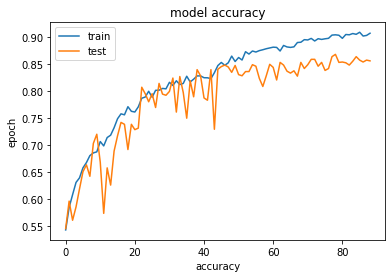

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

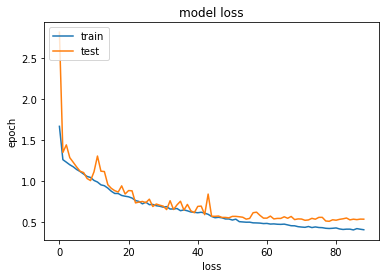

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

(1500, 2)
(1500,)
Confusion Matrix
[[371 379]
 [341 409]]
(1500,)


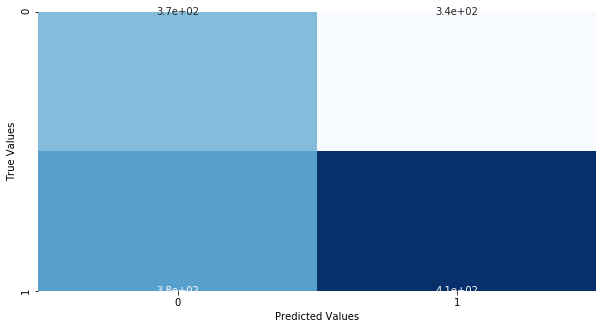

In [10]:
import numpy as np

import seaborn as sns
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize=(10, 10)) # Set Figure

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, 1500 /BATCH_SIZE)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred.shape)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print(validation_generator.classes.shape)
mat = confusion_matrix(validation_generator.classes, y_pred)
# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

Normalized confusion matrix


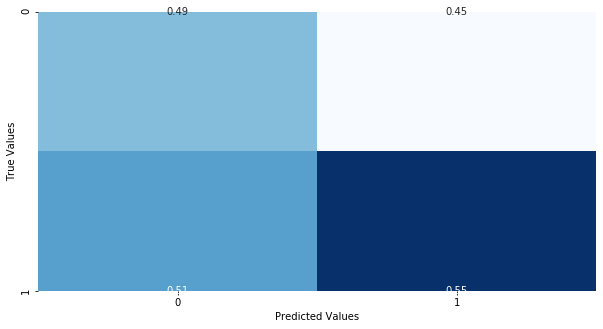

In [11]:
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
print("Normalized confusion matrix")
fig = plt.figure(figsize=(10, 10)) # Set Figure
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [13]:
def evaluate_model(model=None, filepath=None):
    """return the evaluate """
    if not model:
        assert(filepath)
        model = models.load_model(filepath)
    test_generator = image_data_generator('./dogs-vs-cats/test', batch_size=1, shuffle=False)

    nb_samples = len(test_generator)
    score = model.evaluate_generator(test_generator, steps=nb_samples)
    print(score)
    return score

score = evaluate_model(model)

Found 1500 images belonging to 2 classes.
[0.49824115563432375, 0.8746667]


In [14]:
model.save_weights("./Models/Dogs-vs-Cats87_46.h5")